In [1]:

# Configuratins related to Cassandra connector & Cluster
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.datastax.spark:spark-cassandra-connector_2.11:2.3.0 --conf spark.cassandra.connection.host=127.0.0.1 pyspark-shell'
from pyspark.sql import functions

from pyspark.mllib.clustering import LDA, LDAModel
from pyspark.mllib.linalg import Vectors
from pyspark.sql.functions import monotonically_increasing_id
#from google.colab import drive
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql import SQLContext, Row
from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import IDF, StopWordsRemover
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import MinHashLSH
from pyspark.sql.window import Window
from pyspark.sql.functions import rank, col
import pandas as pd
from pyspark.sql import Row
from pyspark.sql.types import StructType
from pyspark.sql.types import StructField
from pyspark.sql.types import StringType, IntegerType, DoubleType
import matplotlib.pyplot as plt


In [2]:
# Creating PySpark SQL Context
from pyspark import SparkContext
sc = SparkContext()

In [3]:
# Creating PySpark SQL Context
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [4]:
# Loads and returns data frame for a table including key space given
def load_and_get_table_df(keys_space_name, table_name):
    table_df = sqlContext.read\
        .format("org.apache.spark.sql.cassandra")\
        .options(table=table_name, keyspace=keys_space_name)\
        .load()
    return table_df

# def load_and_get_table_df(keys_space_name, table_name):
#     table_df = sqlContext.read\
#         .format("com.datastax.spark.connector.cql.Schema$.tableFromCassandra")\
#         .options(table=table_name, keyspace=keys_space_name)\
#         .load()
#     return table_df

In [5]:
# Loading movies & ratings table data frames
# movie_lens is the DB name and movies is the table name
PYSPARK_DF = load_and_get_table_df("bigdata", "reviews")
#ratings = load_and_get_table_df("movie_lens", "ratings")

In [6]:
# First 20 rows of movies table
PYSPARK_DF.count()

1482

In [7]:
import pyspark.sql.functions as f
new_df = PYSPARK_DF.select(['product_id', 'star_rating', 'review_date'])
split_col = f.split(new_df['review_date'], '-')
new_df = new_df.withColumn('year', split_col.getItem(0))
new_df = new_df.select(['product_id', 'star_rating', 'year'])
from pyspark.sql.functions import monotonically_increasing_id

# This will return a new DF with all the columns + id
df = new_df.withColumn("id", monotonically_increasing_id())
# df.filter(df["id"]%3==0).show()
new_df = df.withColumn('Year', df["year"]+(df["id"]%3))
new_df = new_df.select(['product_id', 'star_rating', 'Year'])
new_df.show()


+----------+-----------+------+
|product_id|star_rating|  Year|
+----------+-----------+------+
|B00G2D9672|          5|2015.0|
|B00RFLXB9Y|          5|2016.0|
|B00QW0NGEE|          5|2017.0|
|B00XVQ0PCS|          5|2015.0|
|B0032RCSJ4|          3|2016.0|
|B003EM6AQE|          5|2017.0|
|B00J3PTJZ0|          5|2015.0|
|B00JN9M2S2|          5|2016.0|
|B00OU87JB6|          5|2017.0|
|B001D7C7PA|          4|2015.0|
|B004HARLLA|          5|2016.0|
|B00JP7TCDK|          5|2017.0|
|B00JAZT8O0|          4|2015.0|
|B0098HVXVQ|          5|2016.0|
|B0019ZMZDK|          5|2017.0|
|B0071MSYEE|          5|2015.0|
|B00I8PMQ8I|          5|2016.0|
|B000W91XBO|          5|2017.0|
|B007G95FJE|          4|2015.0|
|B00RHBC0JY|          4|2016.0|
+----------+-----------+------+
only showing top 20 rows



In [8]:
from pyspark.mllib.clustering import LDA, LDAModel
from pyspark.mllib.linalg import Vectors
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql import SQLContext, Row
from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import IDF, StopWordsRemover
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import MinHashLSH
from pyspark.sql.window import Window
from pyspark.sql.functions import rank, col
import pandas as pd
from pyspark.sql import Row
from pyspark.sql.types import StructType
from pyspark.sql.types import StructField
from pyspark.sql.types import StringType, IntegerType, DoubleType


from pyspark.sql import Row
from pyspark.sql.types import *
field = StructType([StructField('Year', DoubleType(), True),
                    StructField('product_id', StringType(), True),
                    StructField('avg(star_rating)', IntegerType(), True)])
schema = StructType(field)
tdf = sqlContext.createDataFrame(sc.emptyRDD(),schema)
# tdf.show()


+----+----------+----------------+
|Year|product_id|avg(star_rating)|
+----+----------+----------------+
+----+----------+----------------+



1482
+------+----------+----------------+
|  Year|product_id|avg(star_rating)|
+------+----------+----------------+
|2015.0|B001BHUJ3E|             5.0|
|2015.0|B007ILM9OO|             5.0|
|2015.0|B00AK8M6MC|             5.0|
+------+----------+----------------+



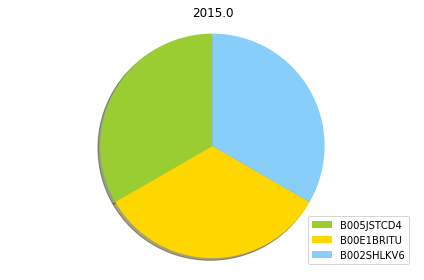

989
+------+----------+----------------+
|  Year|product_id|avg(star_rating)|
+------+----------+----------------+
|2016.0|B00VBBLOJI|             5.0|
|2016.0|B007CB66K8|             5.0|
|2016.0|B008QZTJH6|             5.0|
+------+----------+----------------+



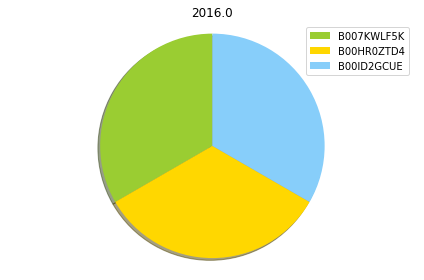

497
+------+----------+----------------+
|  Year|product_id|avg(star_rating)|
+------+----------+----------------+
|2017.0|B00JB1CSX6|             5.0|
|2017.0|B00KDJBHD2|             5.0|
|2017.0|B009SVJ04Y|             5.0|
+------+----------+----------------+



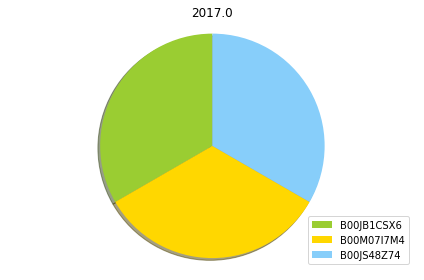

9
+------+----------+----------------+
|  Year|product_id|avg(star_rating)|
+------+----------+----------------+
|2014.0|B015OHQNL8|             5.0|
|2014.0|B01FWRXN0Y|             5.0|
|2014.0|B01694YS8K|             5.0|
+------+----------+----------------+



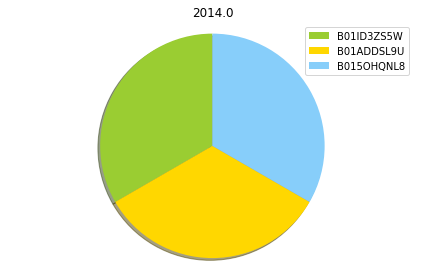

2
+------+----------+----------------+
|  Year|product_id|avg(star_rating)|
+------+----------+----------------+
|2013.0|B01KL6O72Y|             4.0|
+------+----------+----------------+



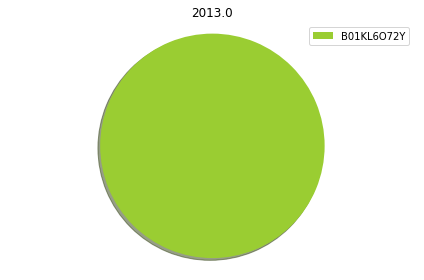

1
+------+----------+----------------+
|  Year|product_id|avg(star_rating)|
+------+----------+----------------+
|2010.0|B0151Z12GO|             5.0|
+------+----------+----------------+



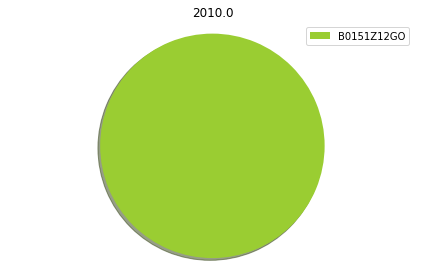

+------+----------+----------------+
|  Year|product_id|avg(star_rating)|
+------+----------+----------------+
|2015.0|B001BHUJ3E|             5.0|
|2015.0|B007ILM9OO|             5.0|
|2015.0|B00AK8M6MC|             5.0|
|2016.0|B00VBBLOJI|             5.0|
|2016.0|B007CB66K8|             5.0|
|2016.0|B008QZTJH6|             5.0|
|2017.0|B00JB1CSX6|             5.0|
|2017.0|B00KDJBHD2|             5.0|
|2017.0|B009SVJ04Y|             5.0|
|2014.0|B015OHQNL8|             5.0|
|2014.0|B01FWRXN0Y|             5.0|
|2014.0|B01694YS8K|             5.0|
|2013.0|B01KL6O72Y|             4.0|
|2010.0|B0151Z12GO|             5.0|
+------+----------+----------------+



In [9]:

# schema = StructType([StructField('Date', IntegerType(), True),
#                      StructField('ID', StringType(), True),
#                      StructField('avg(star)', IntegerType(), True)])
# tdf = sqlContext.createDataFrame([],schema)
# tdf.show()

while(new_df.count() != 0):
    print(new_df.count())
    x = new_df.collect()[0][2]
    df = new_df.filter(new_df["Year"] == x)
#     df.show()
    
    ndf = df.groupby('Year','product_id').agg({'star_rating': 'mean'})
    ndf = ndf.orderBy('avg(star_rating)', ascending=False)
    
    #rdd = sc.parallelize(ndf.take(3))
    #ndf = sqlContext.createDataFrame(ndf.head(3), ndf.schema)
    df1 = ndf.limit(3)
    df1.show()
    
    #     plot
    plt_df = df1.toPandas()
    labels = plt_df['product_id']
    sizes =  plt_df['avg(star_rating)']
    colors = ['yellowgreen', 'gold', 'lightskyblue']
    patches, texts = plt.pie(sizes, colors=colors, shadow=True, startangle=90)
    plt.legend(patches, labels, loc="best")
    plt.title(plt_df.iloc[0,0])
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
    
    tdf = tdf.union(df1)
    new_df = new_df.filter(new_df["Year"] != x)

tdf.show()